In [1]:
import pandas as pd
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from itertools import chain  
from wordcloud import WordCloud

# Importing Raw data

In [2]:
df = pd.read_json('raw_data.json', lines=True)

# Basic Data Exploration 

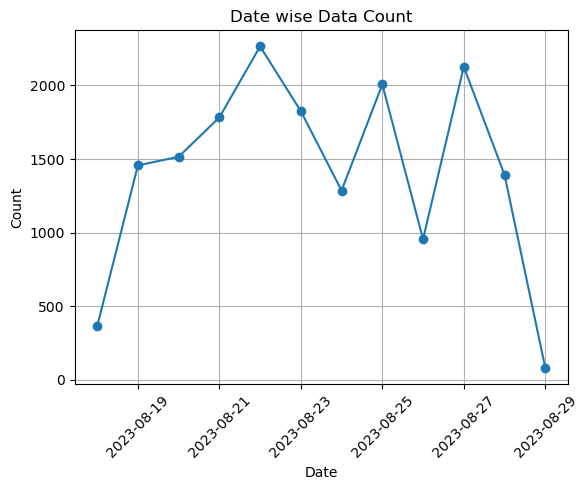

In [3]:
# Convert the "timestamp" column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')

df['date'] = df['timestamp'].dt.date

# Group data by day and count the occurrences
daily_counts = df.groupby('date').size()

# Create a line graph
plt.figure(figsize=(6, 5))
plt.plot(daily_counts.index, daily_counts.values, marker='o')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Date wise Data Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
# Calculate the number of unique posts
unique_post_counts = df['post_title'].nunique()

# Calculate the total number of comments
total_comments = len(df)

# Calculate the average number of comments per post
average_comments_per_post = round(total_comments / unique_post_counts)

print("Number of Posts:", unique_post_counts)
print("Total Number of Comments:", total_comments)
print("Average Number of Comments per Post:", average_comments_per_post)

Number of Posts: 802
Total Number of Comments: 17061
Average Number of Comments per Post: 21


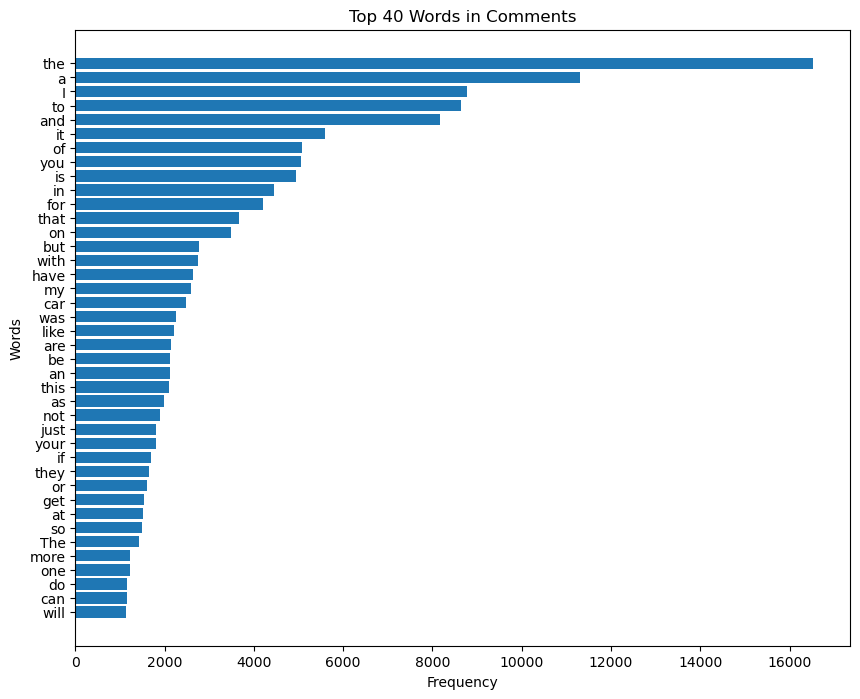

In [5]:
text_corpus = ' '.join(df['comment'])

# Tokenize the text (split into words)
words = text_corpus.split()

# Count the frequency of each word
word_counts = Counter(words)

# Sort the words by frequency in descending order
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Select the top 40 words
top_40_words = sorted_word_counts[:40]

# Extract words and counts for the bar graph
top_words, top_counts = zip(*top_40_words)

# Create a bar graph
plt.figure(figsize=(10, 8))
plt.barh(top_words, top_counts)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 40 Words in Comments')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most frequent words at the top
plt.show()


# Data Cleaning 

Check and remove duplicates if any

In [6]:
duplicate_rows = df[df.duplicated()]
print("Number of Duplicate Rows:")
print(duplicate_rows.shape[0])

Number of Duplicate Rows:
28


In [7]:
df= df.drop_duplicates()

Dropping unwanted columns

In [8]:
columns_to_drop = ['post_body', 'comment_author', 'upvote_ratio', 'timestamp']
df = df.drop(columns=columns_to_drop)

In [9]:
# Making a copy of comment column for further cleaning
df['processed_comment'] = df['comment']

Removing unwanted characters

In [10]:
# Function to check for Unicode characters
def has_unicode(text):
    if isinstance(text, str):
        return any(ord(char) >= 128 for char in text)
    return False

# Function to check for hyperlinks
def has_hyperlinks(text):
    if isinstance(text, str):
        return bool(re.search(r'http[s]?://\S+', text))
    return False

# Function to check for Username tags/mentions
def has_mentions(text):
    if isinstance(text, str):
        return bool(re.search(r'\/?[ur]\/[a-zA-Z0-9_-]+', text))
    return False

# Function to check for digits and numbers
def has_digits_and_numbers(text):
    if isinstance(text, str):
        return bool(re.search(r'\d+', text))
    return False

# Create boolean masks to identify rows with Unicode characters, hyperlinks, and username mentions
unicode_mask = df['processed_comment'].apply(has_unicode) 
hyperlinks_mask = df['processed_comment'].apply(has_hyperlinks) 
mentions_mask = df['processed_comment'].apply(has_mentions) 
digits_and_numbers_mask = df['processed_comment'].apply(has_digits_and_numbers)

# Display no. of rows with Unicode characters
print("Rows with Unicode characters:")
print(df[unicode_mask].shape[0])

# Display no. of rows with hyperlinks
print("\nRows with hyperlinks:")
print(df[hyperlinks_mask].shape[0])

# Display no. of rows with user mentions
print("\nRows with user mentions or subreddit names:")
print(df[mentions_mask].shape[0])

# Display no. of rows with digits and numbers
print("\nRows with digits and numbers:")
print(df[digits_and_numbers_mask].shape[0])

Rows with Unicode characters:
5300

Rows with hyperlinks:
369

Rows with user mentions or subreddit names:
286

Rows with digits and numbers:
6754


In [11]:
def clean_data(df):
    preserved_unicode = ['\u2018','\u2019', '\u2026', '\u2022', '\u201C', '\u201D'] 
    def remove_unicode(text):
        if isinstance(text, str):
            cleaned_text = ''.join([c for c in text if ord(c) < 128 or c in preserved_unicode])
            return cleaned_text
        return text
    
    def remove_hyperlinks(text):
        if isinstance(text, str):
            return re.sub(r'http[s]?://\S+', '', text)
        return text
    
    def remove_user_mentions(text):
        if isinstance(text, str):
            return re.sub(r'\/?[ur]\/[a-zA-Z0-9_-]+', '', text)
        return text

    df_cleaned = df.copy()
    df_cleaned['processed_comment'] = df_cleaned['processed_comment'].apply(remove_unicode)
    df_cleaned['processed_comment'] = df_cleaned['processed_comment'].apply(remove_hyperlinks)
    df_cleaned['processed_comment'] = df_cleaned['processed_comment'].apply(remove_user_mentions)
    return df_cleaned

cleaned_df = clean_data(df)

In [12]:
# Define a list of common contractions
contractions = {
    "i'm": "i am",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "we're": "we are",
    "they're": "they are",
    "i've": "i have",
    "you've": "you have",
    "he's": "he has",
    "she's": "she has",
    "we've": "we have",
    "they've": "they have",
    "i'll": "i will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "it'll": "it will",
    "we'll": "we will",
    "they'll": "they will",
    "i'd": "i would",
    "you'd": "you would",
    "he'd": "he would",
    "she'd": "she would",
    "it'd": "it would",
    "we'd": "we would",
    "they'd": "they would",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "won't": "will not",
    "wouldn't": "would not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "can't": "cannot",
    "couldn't": "could not",
    "shouldn't": "should not",
    "mightn't": "might not",
    "mustn't": "must not",
    "that's":"that is ",
    "what's":"what is",
    "would've":"would have"
}

# Define a function to preprocess comments
def preprocess_comments(comment):
    # Decode HTML entities to handle Unicode characters
    comment = unidecode(comment)

    # Preserve contractions
    for contraction, expanded_form in contractions.items():
        comment = re.sub(rf'\b{contraction}\b', expanded_form, comment, flags=re.IGNORECASE)

    # Remove special characters and numbers
    comment = re.sub(r'[^A-Za-z\s]', '', comment)

    return comment

# Create a new column to store the processed comments
cleaned_df['processed_comment'] = cleaned_df['processed_comment'].apply(preprocess_comments)


Removing Empty Rows

In [13]:
# Remove rows where the 'comments' column is empty or consists of whitespace
cleaned_df = cleaned_df[cleaned_df['processed_comment'].str.strip().astype(bool)]

Case folding 

In [14]:
cleaned_df['processed_comment'] = cleaned_df['processed_comment'].str.lower()

Tokenization

In [15]:
# Tokenize the specified column and create a new column for tokens
cleaned_df['tokens'] = cleaned_df['processed_comment'].apply(lambda x: word_tokenize(x))

Removing Stopwords

In [16]:
# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Create a dictionary to store stop word and single character word counts
stopword_counts = {}

# Function to remove stopwords, single character words, and count them
def remove_stopwords_and_single_chars(tokens):
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    
    # Count stop words and single character words and store their frequencies
    for word in tokens:
        if word in stop_words or len(word) == 1:
            if word in stopword_counts:
                stopword_counts[word] += 1
            else:
                stopword_counts[word] = 1
    
    return filtered_tokens

cleaned_df['filtered_tokens'] = cleaned_df['tokens'].apply(remove_stopwords_and_single_chars)

# Print the stop word and single character word counts
print("Stop Word and Single Character Word Counts:")
for word, count in stopword_counts.items():
    print(f"{word}: {count}")

Stop Word and Single Character Word Counts:
x: 419
g: 350
has: 1130
been: 678
out: 1261
of: 5155
the: 17984
with: 2831
a: 11547
that: 5214
after: 371
its: 494
on: 3647
for: 4446
about: 933
is: 8932
off: 427
i: 13000
to: 8765
who: 326
it: 10232
was: 2471
not: 5989
under: 182
as: 2167
we: 532
only: 704
and: 8595
again: 169
from: 1128
but: 3258
have: 3696
me: 1307
am: 1552
what: 1402
here: 441
an: 2167
there: 692
or: 1710
some: 815
other: 456
should: 484
how: 754
do: 2711
this: 2825
my: 3061
in: 4895
so: 1887
any: 675
be: 2206
he: 569
just: 2117
doing: 220
you: 7124
now: 599
can: 1777
having: 204
being: 466
all: 1269
too: 902
are: 3353
yourself: 158
by: 473
will: 1921
because: 619
them: 770
were: 407
had: 1049
if: 2605
they: 2437
into: 395
why: 533
up: 1025
him: 150
himself: 16
f: 591
when: 961
no: 1145
these: 473
m: 2350
at: 1676
while: 325
did: 912
more: 1325
then: 618
over: 479
until: 156
his: 219
your: 1881
before: 317
where: 316
few: 282
does: 678
z: 111
very: 508
their: 425
s: 411
s

Lemmatization

In [17]:
# Load lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize tokens
def lemmatize_tokens(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos=nltk.corpus.wordnet.VERB) for token in tokens]
    return lemmatized_tokens

cleaned_df['lemmatized_tokens'] = cleaned_df['filtered_tokens'] .apply(lemmatize_tokens)

Sanity Check

In [18]:
# Function to check for Unicode characters
def has_unicode(text):
    if isinstance(text, str):
        return any(ord(char) >= 128 for char in text)
    return False

# Function to check for hyperlinks using regex
def has_hyperlinks(text):
    if isinstance(text, str):
        return bool(re.search(r'http[s]?://\S+', text))
    return False

# Function to check for Username tags/mentions
def has_mentions(text):
    if isinstance(text, str):
        return bool(re.search(r'\/?[ur]\/[a-zA-Z0-9_-]+', text))
    return False

# Function to check for digits and numbers
def has_digits_and_numbers(text):
    if isinstance(text, str):
        return bool(re.search(r'\d+', text))
    return False

# Create boolean masks to identify rows with Unicode characters, hyperlinks, and username mentions
unicode_mask = cleaned_df['processed_comment'].apply(has_unicode)
hyperlinks_mask = cleaned_df['processed_comment'].apply(has_hyperlinks)
mentions_mask = cleaned_df['processed_comment'].apply(has_mentions)
digits_and_numbers_mask = cleaned_df['processed_comment'].apply(has_digits_and_numbers)

# Display no. of rows with Unicode characters
print("Rows with Unicode characters:")
print(cleaned_df[unicode_mask].shape[0])

# Display no. of rows with hyperlinks
print("\nRows with hyperlinks:")
print(cleaned_df[hyperlinks_mask].shape[0])

# Display no. of rows with user mentions
print("\nRows with user mentions or subreddit names:")
print(cleaned_df[mentions_mask].shape[0])

# Display no. of rows with digits and numbers
print("\nRows with digits and numbers:")
print(cleaned_df[digits_and_numbers_mask].shape[0])

Rows with Unicode characters:
0

Rows with hyperlinks:
0

Rows with user mentions or subreddit names:
0

Rows with digits and numbers:
0


In [19]:
# Flatten the list of tokens into a single list of words
all_words = [word for tokens in cleaned_df['lemmatized_tokens'] for word in tokens]

# Count the frequency of each word
word_counts = Counter(all_words)

# Get the top 10 words
top_10_words = word_counts.most_common(20)

# Print the top 10 words and their frequencies
for word, frequency in top_10_words:
    print(f"{word}: {frequency}")

car: 3534
get: 2925
like: 2457
look: 2361
would: 1990
one: 1566
go: 1514
bmw: 1425
drive: 1414
think: 1205
make: 1145
cars: 1061
buy: 1021
new: 962
good: 954
need: 930
also: 878
time: 877
want: 861
see: 843


In [20]:
cleaned_df['lemmatized_tokens'] = cleaned_df['lemmatized_tokens'].apply(lambda tokens: ['car' if word == 'cars' else word for word in tokens])

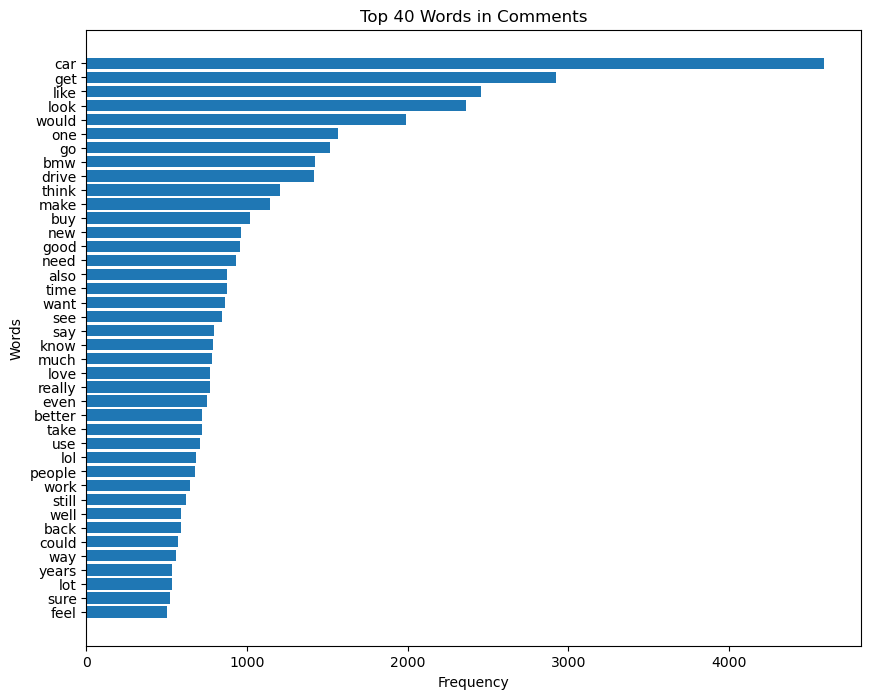

In [21]:
# Flatten the list of lists into a single list
all_tokens = list(chain.from_iterable(cleaned_df['lemmatized_tokens']))

# Count the frequency of each token
token_counts = Counter(all_tokens)

# Sort the tokens by frequency in descending order
sorted_token_counts = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

# Select the top 40 tokens
top_40_tokens = sorted_token_counts[:40]

# Extract tokens and counts for the bar graph
top_tokens, top_counts = zip(*top_40_tokens)

# Create a bar graph
plt.figure(figsize=(10, 8))
plt.barh(top_tokens, top_counts)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 40 Words in Comments')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most frequent tokens at the top
plt.show()


Total Word Count before cleaning the dataset:  405983
Total Word Count after cleaning the dataset: : 195485


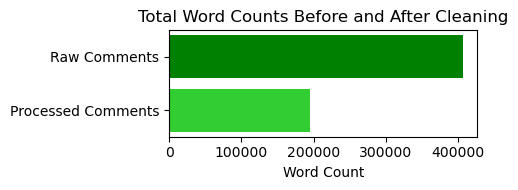

In [22]:
word_count_raw_comments = cleaned_df['comment'].apply(lambda x: len(x.split())).sum()
word_count_processed_comments = cleaned_df['lemmatized_tokens'].apply(lambda x: len(x)).sum()
print("Total Word Count before cleaning the dataset: ", word_count_raw_comments)
print("Total Word Count after cleaning the dataset: :", word_count_processed_comments)

# Create a horizontal bar graph to compare word counts
plt.figure(figsize=(5, 2))
plt.barh(['Raw Comments', 'Processed Comments'], [word_count_raw_comments, word_count_processed_comments], color=['green', 'limegreen'])
plt.xlabel('Word Count')
plt.title('Total Word Counts Before and After Cleaning')
plt.gca().invert_yaxis()  # Invert y-axis to display Raw Comments at the top
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
cleaned_df.to_json('cleaned_data.json', orient='records', lines=True)